<a href="https://colab.research.google.com/github/mmoffattt/CharacterRecognitionProject/blob/main/Michael_Moffatt_CharacterRecognizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import sys
!{sys.executable} -m pip install traja

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 87 kB 3.4 MB/s 


In [ ]:
import pandas as pd
import numpy as np
import xarray as xr

Import tensorflow

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving ujipenchars2.txt to ujipenchars2.txt


In [ ]:
import json
  
  
# the file to be converted to 
# json format
filename = 'ujipenchars2.txt'
  
# dictionary where the lines from
# text will be stored
keys = {'ASCII', 'char', 'example_id', 'numstrokes', 'point_data'}
keys_point_data = {'count', 'points'}

from dataclasses import make_dataclass
Point = make_dataclass("Point", [("x", int), ("y", int)])



# array = np.array([True, 'a', 'trz', 2,
#                     [2, 
#                      [Point(1,2), Point(2,3)]
#                      ]
#                      ])

# creating dictionary

'''
// Non-ASCII char: aacute
WORD á trn_UJI_W01-01
  NUMSTROKES 2
  POINTS 42 # 484 1059 493 1044 493 1044 492 1031 490 1022 477 1021 477 1021 446 1026 428 1035 398 1059 372 1089 345 1127 323 1166 309 1205 301 1239 311 1269 331 1284 364 1287 405 1275 453 1250 501 1220 549 1184 590 1142 623 1103 649 1069 665 1040 670 1022 670 1022 670 1022 652 1040 644 1071 638 1106 635 1145 639 1187 648 1226 662 1260 676 1288 698 1301 719 1307 736 1306 752 1294 763 1276
  POINTS 10 # 580 690 600 673 631 650 665 621 704 600 749 566 794 530 838 503 873 483 904 471
'''

keys = {'ASCII', 'char', 'example_id', 'numstrokes', 'point_data'}
keys_point_data = {'count', 'points'}

dictionary = {}

with open(filename) as fh:

    for line in fh:
        strings = line.strip().split(' ')
        if strings[0] == '//':
          '''
          strings = ['//', 'ASCII', 'char:', 'a']
          '''
          if 'ASCII' not in line:
            continue
          ascii = True if strings[1] == 'ASCII' else False
        if strings[0] == 'WORD':
          '''
          strings = ['WORD', 'a', 'trn_UJI_W01-01']
          '''
          example_id = strings[2] + '_' + strings[1]
          char = strings[1]
        if strings[0] == 'NUMSTROKES':
          '''
          ['NUMSTROKES', '1']
          '''
          numstrokes = strings[1]
          points = []
          count = []
        if strings[0] == 'POINTS':
           
          count.append(int(strings[1]))
          points_array = []
          for x,y in zip(strings[3::2], strings[4::2]):
              points_array.append(Point(int(x),int(y)))
          points.append(pd.DataFrame(points_array))

          
          dictionary[example_id] = {
            'ASCII': ascii,
            'char': char, 
            'numstrokes': numstrokes, 
            'point_data': {
                'count': count,
                'points': points
             }
          }




  


We now have a dictionary of the UNIPEN Data. 
However it is not yet in a format that would allow us a to train a neural network model.

For that we need all of the data to have the same dimensionality.

#Get Stroke Lengths

In [ ]:
# returns list of stroke lengths for an inputted character
def get_stroke_lengths(character):
  characterLengths = []
  for stroke in character['point_data']['points']:
    sum = 0
    for i in range(stroke.shape[0] - 1):
      point_1 = stroke.iloc[i].to_numpy()
      point_2 = stroke.iloc[i+1].to_numpy()
      distance = np.linalg.norm(point_2 - point_1)
      sum += distance
    characterLengths.append(sum)
  return characterLengths

#Uniform Sampling

In [ ]:
from traja import rediscretize_points
import matplotlib.pyplot as plt
import math

# parameters: the current character, a list of stroke lengths, and the number of uniformly distributed points wanted
def resample_character(character, stroke_lengths, num_points_wanted):
  # list of resampled DataFrames
  resampled = []

  # want to distribute num_points_wanted evenly throughout the strokes
  # stores the resampled # of points for each stroke
  num_points_wanted_for_strokes = []
  
  # total length of the given character
  character_length = sum(stroke_lengths)
  
  # stores the number of points for each stroke given by the dictionary
  num_stroke_points_before_processing = [points for points in character['point_data']['count']]

  # if all the points in the character are at the exact same position,
  # add points to the first stroke until the total # of points reaches num_points_wanted
  if (character_length == 0):
    total_points = sum(num_stroke_points_before_processing)
    while (total_points < num_points_wanted):
      first_stroke = character['point_data']['points'][0]
      character['point_data']['points'][0].loc[len(first_stroke.index)] = [first_stroke['x'].iloc[0], first_stroke['y'].iloc[0]]
      total_points += 1
    for stroke in character['point_data']['points']:
      resampled.append(stroke)
  else:
    # based on the length of the stroke, calculate the # of points wanted for each stroke
    # should distribute points evenly between strokes
    for length in stroke_lengths:
      length_percentage = length / character_length
      stroke_num_points_wanted = length_percentage * num_points_wanted
      num_points_wanted_for_strokes.append(stroke_num_points_wanted)

    # since the # of points should be an integer,
    # floor the # of points and add the remainder to the stroke which had the highest decimal value
    decimal_values = [num_points - math.floor(num_points) for num_points in num_points_wanted_for_strokes]
    num_points_wanted_for_strokes = [math.floor(num_points) for num_points in num_points_wanted_for_strokes]
    while (num_points_wanted - sum(num_points_wanted_for_strokes) > 0):
      max_decimal_value = max(decimal_values)
      index = decimal_values.index(max_decimal_value)
      num_points_wanted_for_strokes[index] += 1

    # if a particular stroke had a stroke_length of 0, but other strokes do not
    # there is no way to resample a stroke with no step_length, so just keep # of points the same for that stroke
    for i, stroke in enumerate(character['point_data']['points']):
      if (stroke_lengths[i] == 0):
        for j, num_points in enumerate(num_points_wanted_for_strokes):
          if (num_points != 0):
            num_points_wanted_for_strokes[j] -= num_stroke_points_before_processing[i]

    # resamples strokes based on their calcuated step length
    for i, stroke in enumerate(character['point_data']['points']):
      if (stroke_lengths[i] != 0):
         #step_length for this stroke
        step_length = stroke_lengths[i] / num_points_wanted_for_strokes[i]

        resampled_stroke = stroke.traja.rediscretize(step_length)
        resampled.append(resampled_stroke)
      else:
        resampled.append(stroke)

  return resampled

#Preprocessing Data: Combining Normalization and Uniform Sampling

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
transform_pipeline = Pipeline([('minmax_scaler', MinMaxScaler())])

# stores array of 11640 characters each with 500 points
output_array = []
for key, character in dictionary.items():
  print(character['char'])
  print(key)
  # resample the data for current character
  stroke_lengths = get_stroke_lengths(character)
  num_points_wanted = 500
  resampled_data = resample_character(character, stroke_lengths, num_points_wanted)

  # apply MinMaxScaler to data
  current_char = np.zeros(shape=(num_points_wanted, 2))
  i = 0
  for resampled_stroke in resampled_data:
    normalized_data = transform_pipeline.fit_transform(resampled_stroke)
    for row in normalized_data:
      if(i < num_points_wanted):
        current_char[i] = row
        i +=1

  # sometimes the resampling is slightly off,
  # so if the # of points in the character is less than num_points_wanted,
  # just duplicate the last point
  while (i < num_points_wanted):
    current_char[i] = current_char[i-1]
    i += 1

  output_array.append(current_char)
  
output_array = np.array(output_array)
print(type(output_array))
print(np.shape(output_array))

Streaming output truncated to the last 5000 lines.
l
tst_UPV_W48-02_l
m
tst_UPV_W48-01_m
m
tst_UPV_W48-02_m
n
tst_UPV_W48-01_n
n
tst_UPV_W48-02_n
ñ
tst_UPV_W48-01_ñ
ñ
tst_UPV_W48-02_ñ
o
tst_UPV_W48-01_o
o
tst_UPV_W48-02_o
p
tst_UPV_W48-01_p
p
tst_UPV_W48-02_p
q
tst_UPV_W48-01_q
q
tst_UPV_W48-02_q
r
tst_UPV_W48-01_r
r
tst_UPV_W48-02_r
s
tst_UPV_W48-01_s
s
tst_UPV_W48-02_s
t
tst_UPV_W48-01_t
t
tst_UPV_W48-02_t
u
tst_UPV_W48-01_u
u
tst_UPV_W48-02_u
v
tst_UPV_W48-01_v
v
tst_UPV_W48-02_v
w
tst_UPV_W48-01_w
w
tst_UPV_W48-02_w
x
tst_UPV_W48-01_x
x
tst_UPV_W48-02_x
y
tst_UPV_W48-01_y
y
tst_UPV_W48-02_y
z
tst_UPV_W48-01_z
z
tst_UPV_W48-02_z
á
tst_UPV_W48-01_á
á
tst_UPV_W48-02_á
é
tst_UPV_W48-01_é
é
tst_UPV_W48-02_é
í
tst_UPV_W48-01_í
í
tst_UPV_W48-02_í
ó
tst_UPV_W48-01_ó
ó
tst_UPV_W48-02_ó
ú
tst_UPV_W48-01_ú
ú
tst_UPV_W48-02_ú
ü
tst_UPV_W48-01_ü
ü
tst_UPV_W48-02_ü
A
tst_UPV_W48-01_A
A
tst_UPV_W48-02_A
B
tst_UPV_W48-01_B
B
tst_UPV_W48-02_B
C
tst_UPV_W48-01_C
C
tst_UPV_W48-02_C
D
tst_UPV_W48-01_D

#Save and Download Preprocessed Data

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
arr_reshaped = output_array.reshape(output_array.shape[0], -1)
np.savetxt('preprocessed_data_500_pts.txt', arr_reshaped)

In [ ]:
loaded_arr = np.loadtxt('preprocessed_data_500_pts.txt')
# output_array.shape[2] = 2
# so replaced output_array.shape[2] with 2
output_array = loaded_arr.reshape(loaded_arr.shape[0], loaded_arr.shape[1] // 2, 2)
print(np.shape(output_array))

(11640, 500, 2)


#One Hot Encoder

In [ ]:
from sklearn.preprocessing import OneHotEncoder
label_encoder = OneHotEncoder(sparse=False)
character_types = []
for value in dictionary.values():
  for char in value['char']:
    character_types.append(char)
character_types = pd.DataFrame(character_types)

character_labels_1hot = label_encoder.fit_transform(character_types)
print(np.shape(character_labels_1hot))

(11640, 97)


#Ordinal Encoder

In [ ]:
from sklearn.preprocessing import OrdinalEncoder
label_encoder = OrdinalEncoder()
character_types = []
for value in dictionary.values():
  for char in value['char']:
    character_types.append(char)
character_types = pd.DataFrame(character_types)

character_labels_ordinal = label_encoder.fit_transform(character_types)
print(np.shape(character_labels_ordinal))

(11640, 1)


#Get Smaller Data Set of a-z Characters

In [ ]:
indices = [idx for idx,val in enumerate(character_labels_ordinal) if (val <= 77 and val >= 52)]
print(np.shape(indices))

smaller_data_set_labels_ordinal = [val for val in character_labels_ordinal if (val <= 77 and val >= 52)]
smaller_data_set_labels_ordinal = np.array(smaller_data_set_labels_ordinal)
print(smaller_data_set_labels_ordinal)

smaller_data_set = [character for i,character in enumerate(output_array) if (i in indices)]
smaller_data_set = np.array(smaller_data_set)
print(np.shape(smaller_data_set))

(3120,)
[[52.]
 [52.]
 [53.]
 ...
 [76.]
 [77.]
 [77.]]
(3120, 500, 2)


#Splitting Data

In [ ]:
from sklearn.model_selection import train_test_split

print(np.shape(output_array))
print(np.shape(character_labels_ordinal))
X_train, X_, y_train, y_ = train_test_split(output_array, character_labels_ordinal, train_size=0.7, stratify=character_labels_ordinal)

X_val, X_test, y_val, y_test = train_test_split(X_, y_, train_size=0.5, stratify=y_)

# Training Data:
# X_train, y_train
# (X is the feature input, y is the target values (labels))
# Validation Data:
# X_val, y_val
# Test Data:
# X_test, y_test

(11640, 500, 2)
(11640, 1)


#Implementing Neural Network

In [ ]:
from tensorflow import keras

In [ ]:
tf.__version__

'2.8.2'

In [ ]:
keras.__version__

'2.8.0'

In [ ]:
from tensorflow.python.keras import layers

model = keras.models.Sequential([
    layers.Flatten(input_shape=[num_points_wanted, 2]),
    layers.Dense(units=210, activation='relu'),
    layers.Dense(units=210, activation='relu'),
    layers.Dense(units=97, activation='softmax')
])

# use categorical_crossentropy when target is one-hot encoded
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

print(np.shape(X_train))
print(np.shape(y_train))
print(np.shape(X_val))
print(np.shape(y_val))
history = model.fit(X_train, y_train, epochs=25, 
          validation_data=(X_val, y_val))

(8147, 500, 2)
(8147, 1)
(1746, 500, 2)
(1746, 1)
Epoch 1/25
255/255 [==============================] - 2s 5ms/step - loss: 3.1114 - accuracy: 0.2619 - val_loss: 2.2720 - val_accuracy: 0.4129
Epoch 2/25
255/255 [==============================] - 1s 4ms/step - loss: 1.9420 - accuracy: 0.4803 - val_loss: 1.8669 - val_accuracy: 0.4931
Epoch 3/25
255/255 [==============================] - 1s 4ms/step - loss: 1.5917 - accuracy: 0.5586 - val_loss: 1.5982 - val_accuracy: 0.5493
Epoch 4/25
255/255 [==============================] - 1s 4ms/step - loss: 1.3866 - accuracy: 0.5945 - val_loss: 1.4470 - val_accuracy: 0.5836
Epoch 5/25
255/255 [==============================] - 1s 4ms/step - loss: 1.2582 - accuracy: 0.6138 - val_loss: 1.3792 - val_accuracy: 0.5911
Epoch 6/25
255/255 [==============================] - 1s 5ms/step - loss: 1.1412 - accuracy: 0.6450 - val_loss: 1.3780 - val_accuracy: 0.5939
Epoch 7/25
255/255 [==============================] - 1s 5ms/step - loss: 1.0570 - accuracy: 0.666

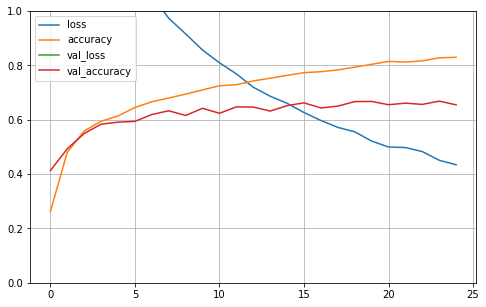

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [ ]:
model.evaluate(X_test, y_test)

55/55 [==============================] - 0s 1ms/step - loss: 1.4662 - accuracy: 0.6525


[1.4662123918533325, 0.6525472402572632]

#Analyzing Neural Network Incorrect Characters

In [ ]:
# a-z: 52 - 77
# ñ: 92
# A-Z: 26 - 51
# 0 - 10: 10 - 19
# . : 9
# , : 7
# ; : 21
with np.printoptions(threshold=np.inf):
    print(character_labels_ordinal)

[[52.]
 [52.]
 [53.]
 [53.]
 [54.]
 [54.]
 [55.]
 [55.]
 [56.]
 [56.]
 [57.]
 [57.]
 [58.]
 [58.]
 [59.]
 [59.]
 [60.]
 [60.]
 [61.]
 [61.]
 [62.]
 [62.]
 [63.]
 [63.]
 [64.]
 [64.]
 [65.]
 [65.]
 [92.]
 [92.]
 [66.]
 [66.]
 [67.]
 [67.]
 [68.]
 [68.]
 [69.]
 [69.]
 [70.]
 [70.]
 [71.]
 [71.]
 [72.]
 [72.]
 [73.]
 [73.]
 [74.]
 [74.]
 [75.]
 [75.]
 [76.]
 [76.]
 [77.]
 [77.]
 [89.]
 [89.]
 [90.]
 [90.]
 [91.]
 [91.]
 [93.]
 [93.]
 [94.]
 [94.]
 [95.]
 [95.]
 [26.]
 [26.]
 [27.]
 [27.]
 [28.]
 [28.]
 [29.]
 [29.]
 [30.]
 [30.]
 [31.]
 [31.]
 [32.]
 [32.]
 [33.]
 [33.]
 [34.]
 [34.]
 [35.]
 [35.]
 [36.]
 [36.]
 [37.]
 [37.]
 [38.]
 [38.]
 [39.]
 [39.]
 [85.]
 [85.]
 [40.]
 [40.]
 [41.]
 [41.]
 [42.]
 [42.]
 [43.]
 [43.]
 [44.]
 [44.]
 [45.]
 [45.]
 [46.]
 [46.]
 [47.]
 [47.]
 [48.]
 [48.]
 [49.]
 [49.]
 [50.]
 [50.]
 [51.]
 [51.]
 [82.]
 [82.]
 [83.]
 [83.]
 [84.]
 [84.]
 [86.]
 [86.]
 [87.]
 [87.]
 [88.]
 [88.]
 [10.]
 [10.]
 [11.]
 [11.]
 [12.]
 [12.]
 [13.]
 [13.]
 [14.]
 [14.]
 [15.]

In [ ]:
for i in range(50):
  test_input = output_array[i:i+1]
  prediction = model.predict(test_input)
  prediction_p = tf.nn.softmax(prediction)
  yhat = np.argmax(prediction_p)
  print(yhat)

#Examples:
#mistakes c for U
#mistakes g for q
#mistakes i for ¡

52
52
53
53
28
28
55
55
56
56
57
57
68
58
59
59
60
4
61
61
62
62
4
4
64
64
65
65
92
92
66
66
67
67
68
68
69
69
70
44
71
71
72
46
46
73
48
20
75
75


#Fine-Tuning Neural Network Hyperparameters

In [ ]:
def build_model(loss='sparse_categorical_crossentropy', optimizer= 'adam', n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=[num_points_wanted, 2]):
  model = keras.models.Sequential()
  model.add(keras.layers.Flatten(input_shape=input_shape))
  for layer in range(n_hidden):
    model.add(keras.layers.Dense(n_neurons, activation='relu'))
  model.add(keras.layers.Dense(97, activation='softmax'))
  model.compile(loss=loss, optimizer=optimizer)
  return model

In [ ]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

# tests different number of hidden layers, number of neurons, and learning rates to see which produces the most accurate predictions
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)
param_distribs = {
    "n_hidden": [0, 1, 2, 3],
    "n_neurons": np.arange(1, 300),
    "learning_rate": reciprocal(3e-4, 3e-2)
}
rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, cv=3)
rnd_search_cv.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  after removing the cwd from sys.path.


46/46 [==============================] - 1s 8ms/step - loss: 2.8346 - val_loss: 1.8184
Epoch 2/100
46/46 [==============================] - 0s 6ms/step - loss: 1.4392 - val_loss: 1.2973
Epoch 3/100
46/46 [==============================] - 0s 7ms/step - loss: 1.1103 - val_loss: 1.0397
Epoch 4/100
46/46 [==============================] - 0s 6ms/step - loss: 0.8854 - val_loss: 0.9568
Epoch 5/100
46/46 [==============================] - 0s 7ms/step - loss: 0.7109 - val_loss: 0.7644
Epoch 6/100
46/46 [==============================] - 0s 6ms/step - loss: 0.6419 - val_loss: 0.8521
Epoch 7/100
46/46 [==============================] - 0s 7ms/step - loss: 0.5705 - val_loss: 0.7885
Epoch 8/100
46/46 [==============================] - 0s 6ms/step - loss: 0.5401 - val_loss: 0.6863
Epoch 9/100
46/46 [==============================] - 0s 7ms/step - loss: 0.4639 - val_loss: 0.6495
Epoch 10/100
46/46 [==============================] - 0s 6ms/step - loss: 0.4557 - val_loss: 0.6612
Epoch 11/100
46/46 [=

RandomizedSearchCV(cv=3,
                   estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x7ff53497b7d0>,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ff534978250>,
                                        'n_hidden': [0, 1, 2, 3],
                                        'n_neurons': array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38...
       209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,
       222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234,
       235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247,
       248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260,
       261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273,
       274, 275, 276, 277, 278, 279, 280, 281, 282, 28

In [ ]:
rnd_search_cv.best_params_

{'learning_rate': 0.0006431443212654279, 'n_hidden': 2, 'n_neurons': 210}

In [ ]:
rnd_search_cv.best_score_

-0.5779930353164673

In [ ]:
model = rnd_search_cv.best_estimator_.model
model.evaluate(X_test, y_test)

15/15 [==============================] - 0s 3ms/step - loss: 0.6742


0.6741690635681152